In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import warnings as wr 
import sklearn

wr.filterwarnings('ignore') 

In [2]:
df = pd.read_csv(r'C:\Users\cg\Desktop\nics.csv')

In [3]:
df.shape

(598, 5)

In [4]:
df.head()

,Date,state,handgun,long_gun,totals
0,9/1/2023,Texas,46450,35984,123482
1,8/1/2023,Texas,47559,30913,122787
2,7/1/2023,Texas,47650,23317,109274
3,6/1/2023,Texas,51381,24918,121507
4,5/1/2023,Texas,58444,27280,125580


In [5]:
df = df.rename(columns={
    "state": "State", 
    "handgun": "Handguns", 
    "long_gun": "LongGuns",
})
df.head()

,Date,State,Handguns,LongGuns,totals
0,9/1/2023,Texas,46450,35984,123482
1,8/1/2023,Texas,47559,30913,122787
2,7/1/2023,Texas,47650,23317,109274
3,6/1/2023,Texas,51381,24918,121507
4,5/1/2023,Texas,58444,27280,125580


In [6]:
df = df.sort_values(by=['State', 'Date'], ascending = [True, True])

df.reset_index(inplace = True, drop = True)
df.head()

,Date,State,Handguns,LongGuns,totals
0,1/1/1999,California,25989,23653,56953
1,1/1/2000,California,22711,22830,57800
2,1/1/2001,California,21812,24292,60935
3,1/1/2002,California,18590,19914,58768
4,1/1/2003,California,10947,15831,39285


In [7]:
df['Date'] = pd.to_datetime(df['Date'])

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 598 entries, 0 to 597
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      598 non-null    datetime64[ns]
 1   State     598 non-null    object        
 2   Handguns  598 non-null    int64         
 3   LongGuns  598 non-null    int64         
 4   totals    598 non-null    int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 23.5+ KB


In [9]:
# Number of Null Values in Each Column
df.isna().sum()

Date        0
State       0
Handguns    0
LongGuns    0
totals      0
dtype: int64

In [10]:
df.Date.max()

Timestamp('2023-09-01 00:00:00')

In [11]:
df['Quarter'] = df['Date'].dt.to_period('Q').dt.to_timestamp()
df['Year'] = df['Date'].dt.to_period('Y').dt.to_timestamp()
df.head()

,Date,State,Handguns,LongGuns,totals,Quarter,Year
0,1999-01-01,California,25989,23653,56953,1999-01-01,1999-01-01
1,2000-01-01,California,22711,22830,57800,2000-01-01,2000-01-01
2,2001-01-01,California,21812,24292,60935,2001-01-01,2001-01-01
3,2002-01-01,California,18590,19914,58768,2002-01-01,2002-01-01
4,2003-01-01,California,10947,15831,39285,2003-01-01,2003-01-01


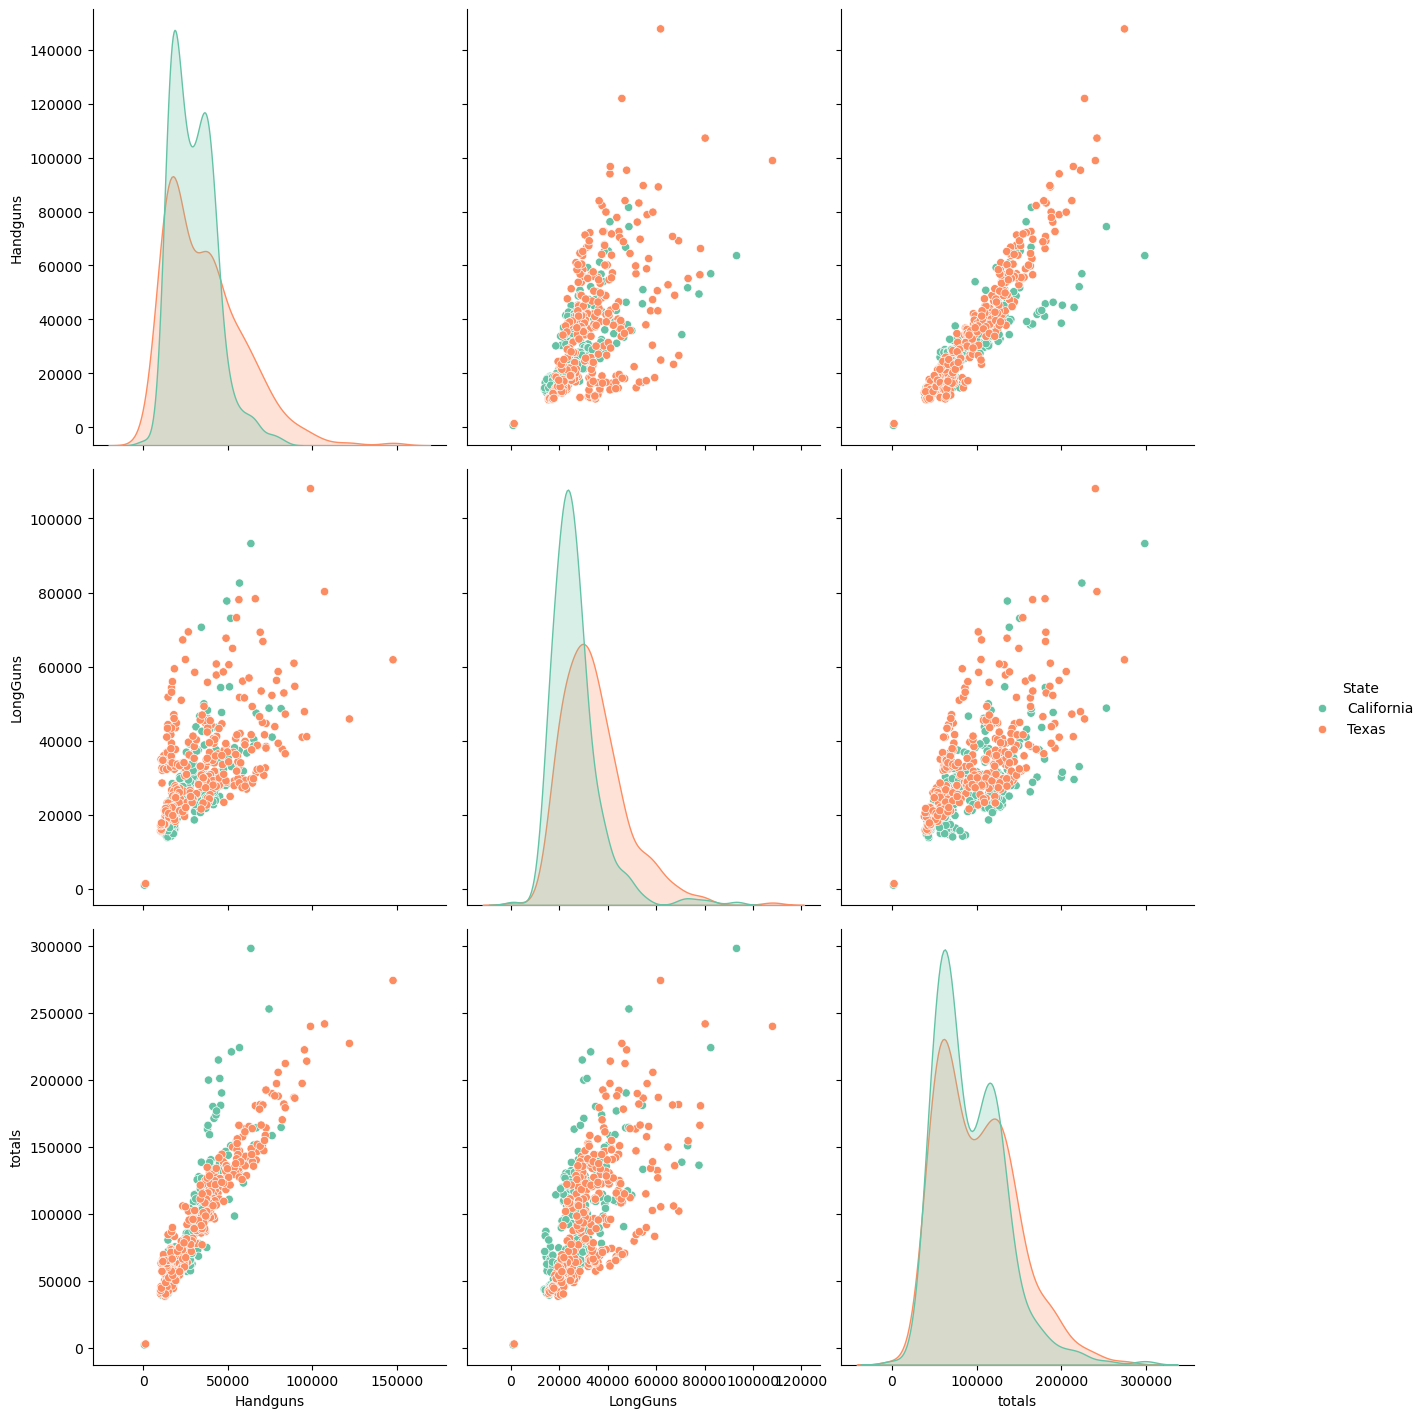

In [12]:
sns.set_palette("Set2") 

pp = sns.pairplot(df, hue="State")

pp.fig.set_size_inches(15,15)

In [13]:
timeframes = ['Date', 'Quarter', 'Year'] 

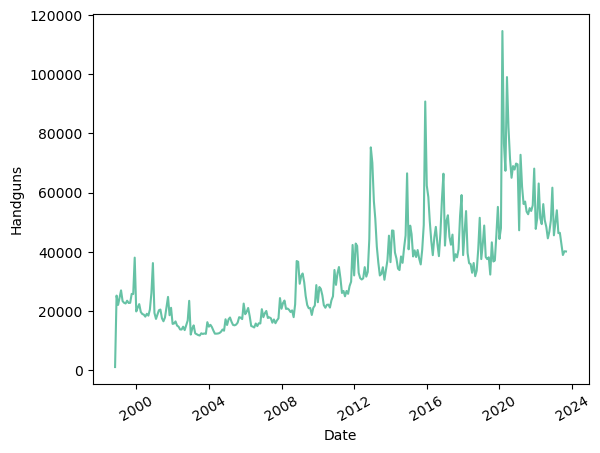

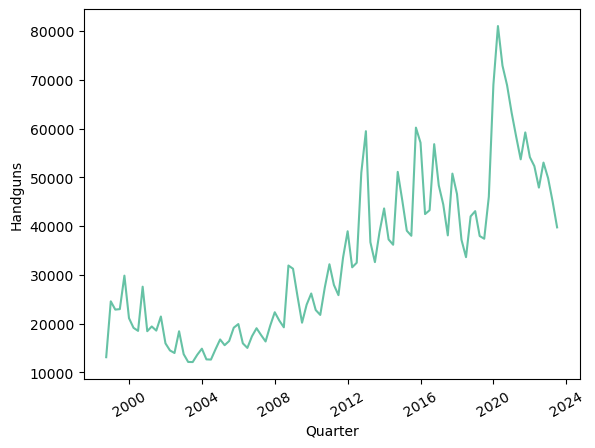

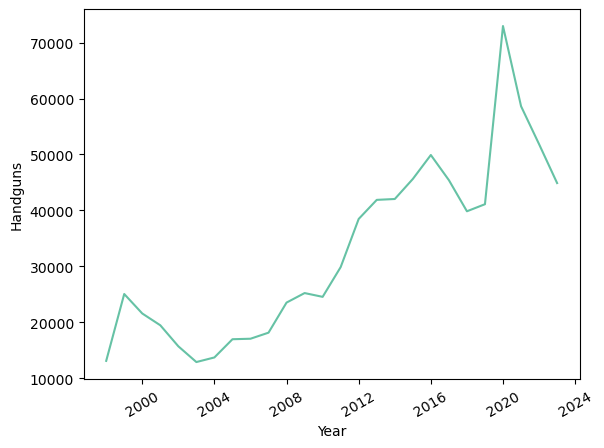

In [14]:
for tf in timeframes:
    sns.lineplot(data = df, x = df[tf], y = df['Handguns'], ci=None)
    plt.xticks(rotation=30)
    plt.show()

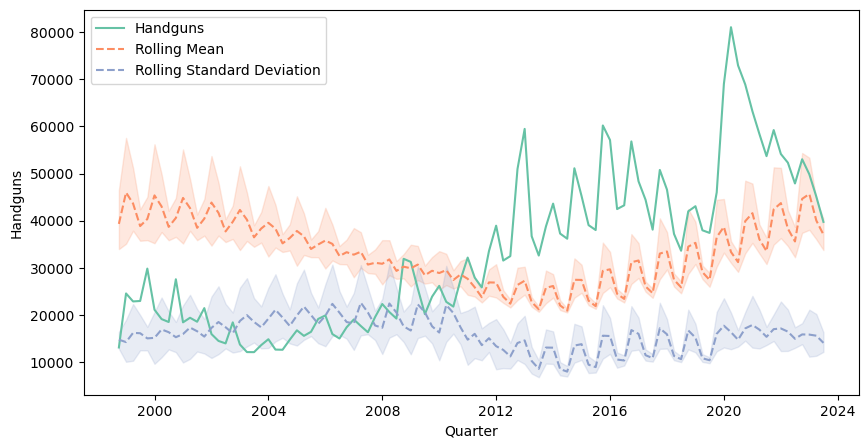

In [15]:
df['rollingMean'] = df.Handguns.rolling(window = 16).mean()
df['rollingstd'] = df.Handguns.rolling(window = 16).std()

plt.figure(figsize = (10, 5))
sns.lineplot(data = df, x = df['Quarter'], y = df['Handguns'], label = "Handguns", ci=None)
sns.lineplot(data = df, x = df['Quarter'], y = df['rollingMean'], label = "Rolling Mean", linestyle='dashed')
sns.lineplot(data = df, x = df['Quarter'], y = df['rollingstd'], label = "Rolling Standard Deviation", linestyle='dashed')
plt.legend(loc = 'upper left')

# Select Analysis Data

In [16]:
# Group DF2 by Timeframe
df3 = df.groupby(['Quarter'], as_index=False)['Handguns'].sum()

In [17]:
data = pd.Series(df3['Handguns']).set_axis(df3['Quarter'])

# Stationarity Analysis w/ ADF, ACF/PACF Plots

In [18]:
from statsmodels.tsa.stattools import adfuller

In [19]:
adf = adfuller(data)
print(adf)

(-1.343875990271154, 0.6088677626309358, 5, 94, {'1%': -3.5019123847798657, '5%': -2.892815255482889, '10%': -2.583453861475781}, 2063.7626761655865)


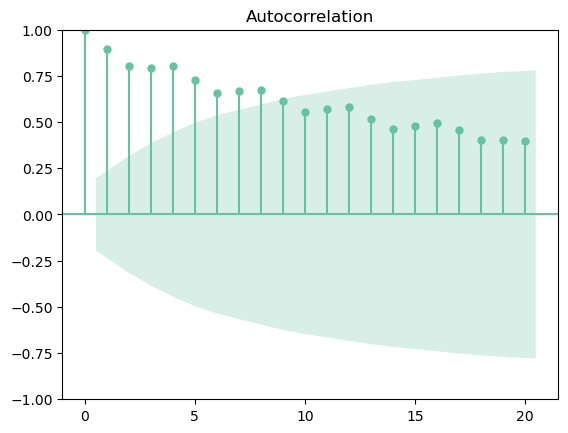

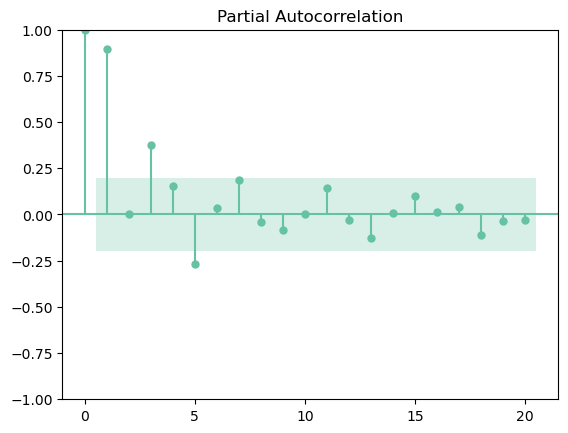

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(data)
plot_pacf(data)
plt.show()

# Time Series Decomposition & Anomaly Detection

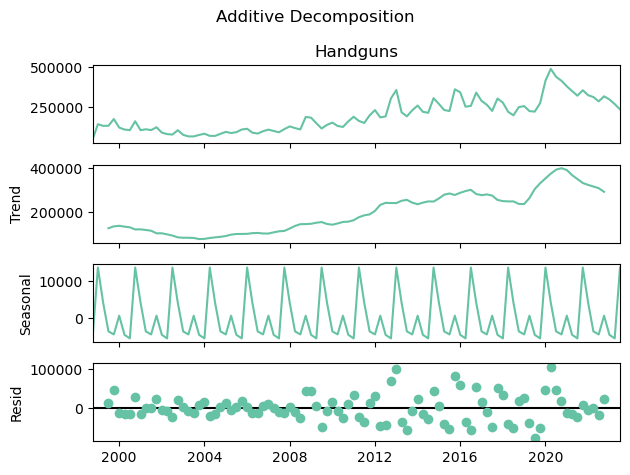

In [29]:
# To further examine our seasonality, let's decompose our data.
from statsmodels.tsa.seasonal import seasonal_decompose

ad = seasonal_decompose(data, model = 'additive', period = 7)
ad.plot()
plt.suptitle('Additive Decomposition')
plt.tight_layout(rect = [0, 0, 1, 1])

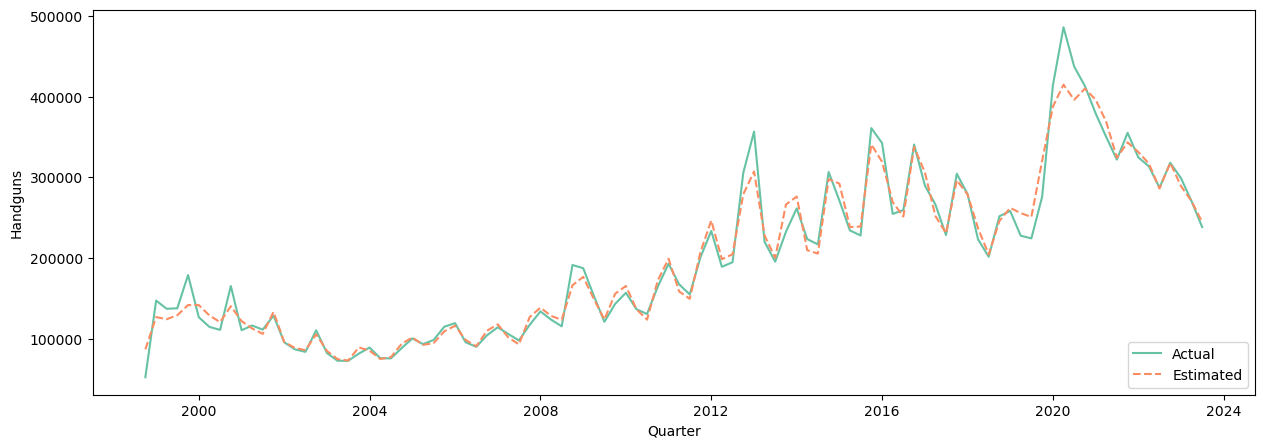

In [30]:
from statsmodels.tsa.seasonal import STL
stl = STL(data)
result = stl.fit()
seasonal, trend, resid = result.seasonal, result.trend, result.resid
estimated = seasonal+trend

plt.figure(figsize=(15, 5))
sns.lineplot(data, label='Actual')
sns.lineplot(estimated, label = 'Estimated', linestyle='dashed')
plt.legend(loc = 'lower right')

(10500.0, 18353.0)

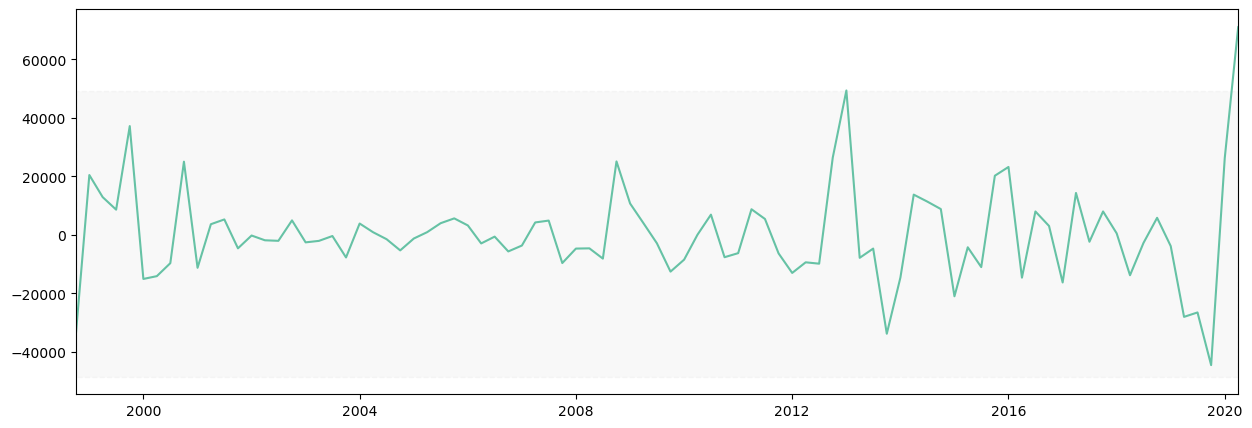

In [33]:
# Residuals outside 3 standard Deviations are outliers

resid_mu = resid.mean()
resid_dev = resid.std()

lower = resid_mu - 3*resid_dev #lower limit is 3 standard deviations away from the mean
upper = resid_mu + 3*resid_dev #upper limit is 3 standard deviations away from the mean

plt.figure(figsize=(15, 5))
plt.plot(resid)

plt.fill_between([data.idxmin(), data.idxmax()], lower, upper, color='gray', alpha = .05, linestyle = "--")
plt.xlim(data.idxmin(), data.idxmax())

In [34]:
resid

Quarter
1998-10-01   -34613.015606
1999-01-01    20468.714893
1999-04-01    12920.959583
1999-07-01     8632.403993
1999-10-01    37209.149529
                  ...     
2022-07-01     1110.585095
2022-10-01      142.198878
2023-01-01     9906.570941
2023-04-01      -92.237344
2023-07-01    -6136.712896
Name: resid, Length: 100, dtype: float64

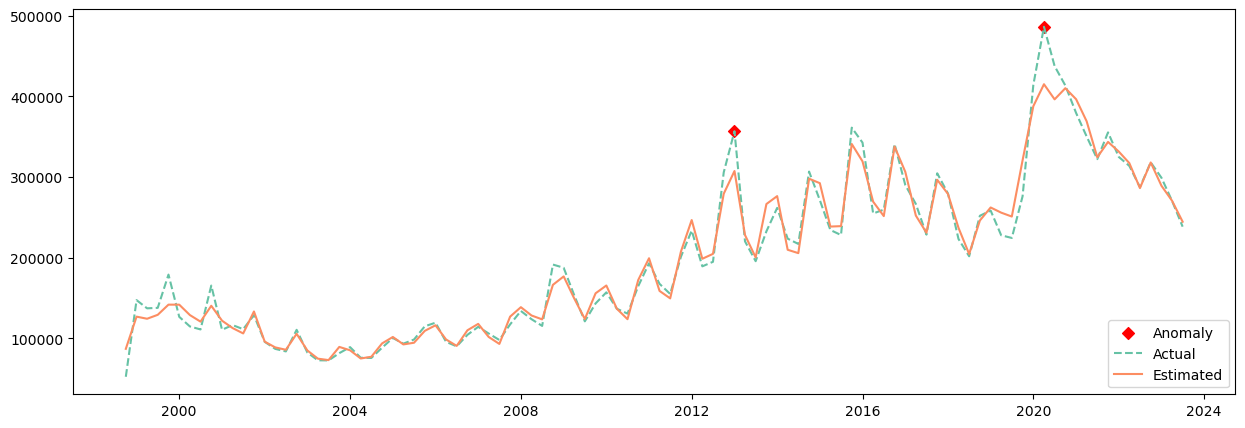

In [35]:
#Plot anomalies on original data

anomalies = data[(resid < lower)|(resid > upper)]
plt.figure(figsize=(15, 5))
plt.scatter(anomalies.index, anomalies.values, color = 'r', marker = 'D', label = 'Anomaly')
plt.plot(data, label='Actual', linestyle = '--')
plt.plot(estimated, label = 'Estimated')

plt.legend(loc = 'lower right')

In [36]:
anomalies

Quarter
2013-01-01    356781
2020-04-01    486123
Name: Handguns, dtype: int64

# Differencing Data

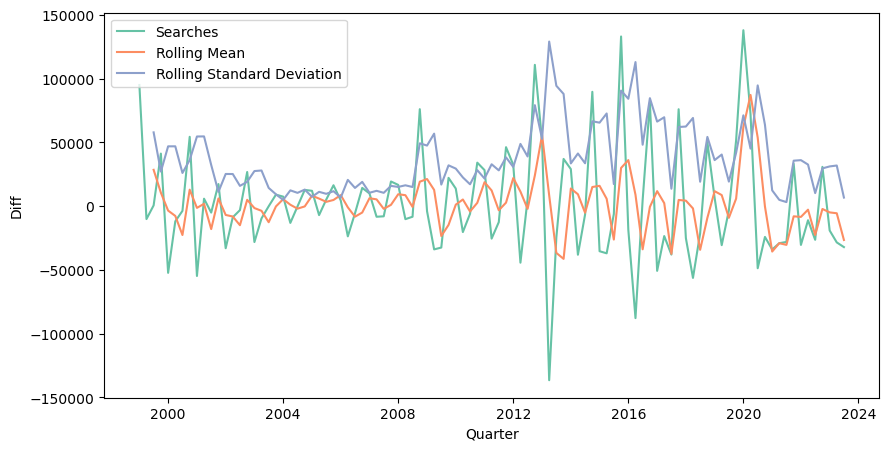

In [38]:
df4 = df3

df4['Diff'] = df4['Handguns'].diff()
df4

df4['rollingMean'] = df4.Diff.rolling(window = 3).mean()
df4['rollingstd'] = df4.Diff.rolling(window = 3).std()
df4

plt.figure(figsize = (10, 5))
sns.lineplot(data = df4, x = df4['Quarter'], y = df4['Diff'], label = "Searches")
sns.lineplot(data = df4, x = df4['Quarter'], y = df4['rollingMean'], label = "Rolling Mean", errorbar = ('sd', 2))
sns.lineplot(data = df4, x = df4['Quarter'], y = df4['rollingstd'], label = "Rolling Standard Deviation", errorbar = ('sd', 2))
plt.legend(loc = 'upper left')

In [40]:
data2 = pd.Series(df4['Diff']).set_axis(df4['Quarter']).dropna()

adf = adfuller(data2)
print(adf)

(-5.261090033583788, 6.588869294591648e-06, 5, 93, {'1%': -3.502704609582561, '5%': -2.8931578098779522, '10%': -2.583636712914788}, 2040.697345728249)


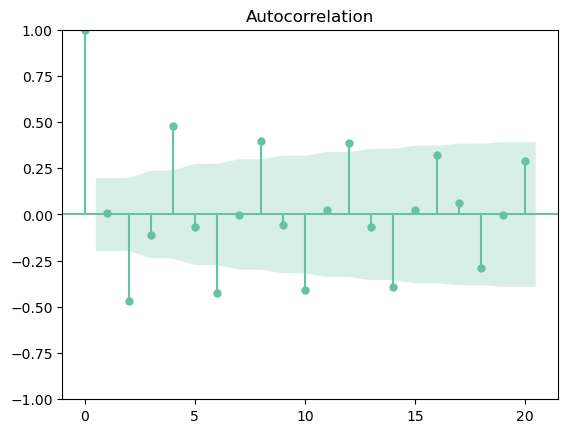

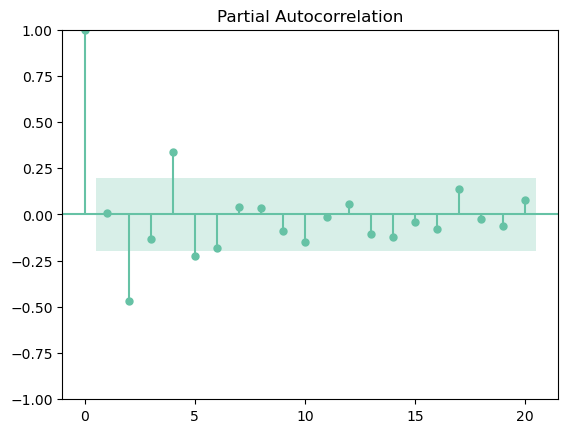

In [41]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(data2)
plot_pacf(data2)
plt.show()

# Training and Testing Sets

In [43]:
train = data[:round(len(data)*.85)]
test = data[round(len(data)*.85):]
print(f'Train Size: {len(train)}, Test Size: {len(test)}')

Train Size: 85, Test Size: 15


# Scaled Data

In [44]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train.values.reshape(-1, 1))
test_scaled = scaler.fit_transform(test.values.reshape(-1, 1))

# SARIMAX Modeling

In [62]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(train_scaled, seasonal_order = (0, 1, 1, 4))
model_fit = model.fit()
print(model_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                   85
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 4)   Log Likelihood                 -34.865
Date:                             Fri, 23 Aug 2024   AIC                             75.730
Time:                                     13:25:48   BIC                             82.913
Sample:                                          0   HQIC                            78.612
                                              - 85                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7572      0.053     14.212      0.000       0.653       0.862
ma.S.L4       -0.5532      

In [63]:
# Forecasts

forecast_steps = len(test)
forecast_scaled = model_fit.get_forecast(steps=forecast_steps)
forecast_index = test.index

fvs = forecast_scaled.predicted_mean
fvd = scaler.inverse_transform(fvs.reshape(-1, 1))
forecast_values = pd.Series(fvd.flatten(), index = forecast_index)

In [64]:
forecast_values

Quarter
2020-01-01    427230.588906
2020-04-01    393383.065742
2020-07-01    384173.698169
2020-10-01    436696.370051
2021-01-01    428750.077578
2021-04-01    394533.582841
2021-07-01    385044.839639
2021-10-01    437355.975599
2022-01-01    429249.513655
2022-04-01    394911.742782
2022-07-01    385331.172460
2022-10-01    437572.779326
2023-01-01    429413.671769
2023-04-01    395036.039015
2023-07-01    385425.286318
dtype: float64

In [65]:
# Confidence Intervals

cis = forecast_scaled.conf_int()
cid = scaler.inverse_transform(cis)
ciLower = pd.Series(cid[:,0], index = forecast_index)
ciUpper = pd.Series(cid[:,1], index = forecast_index)

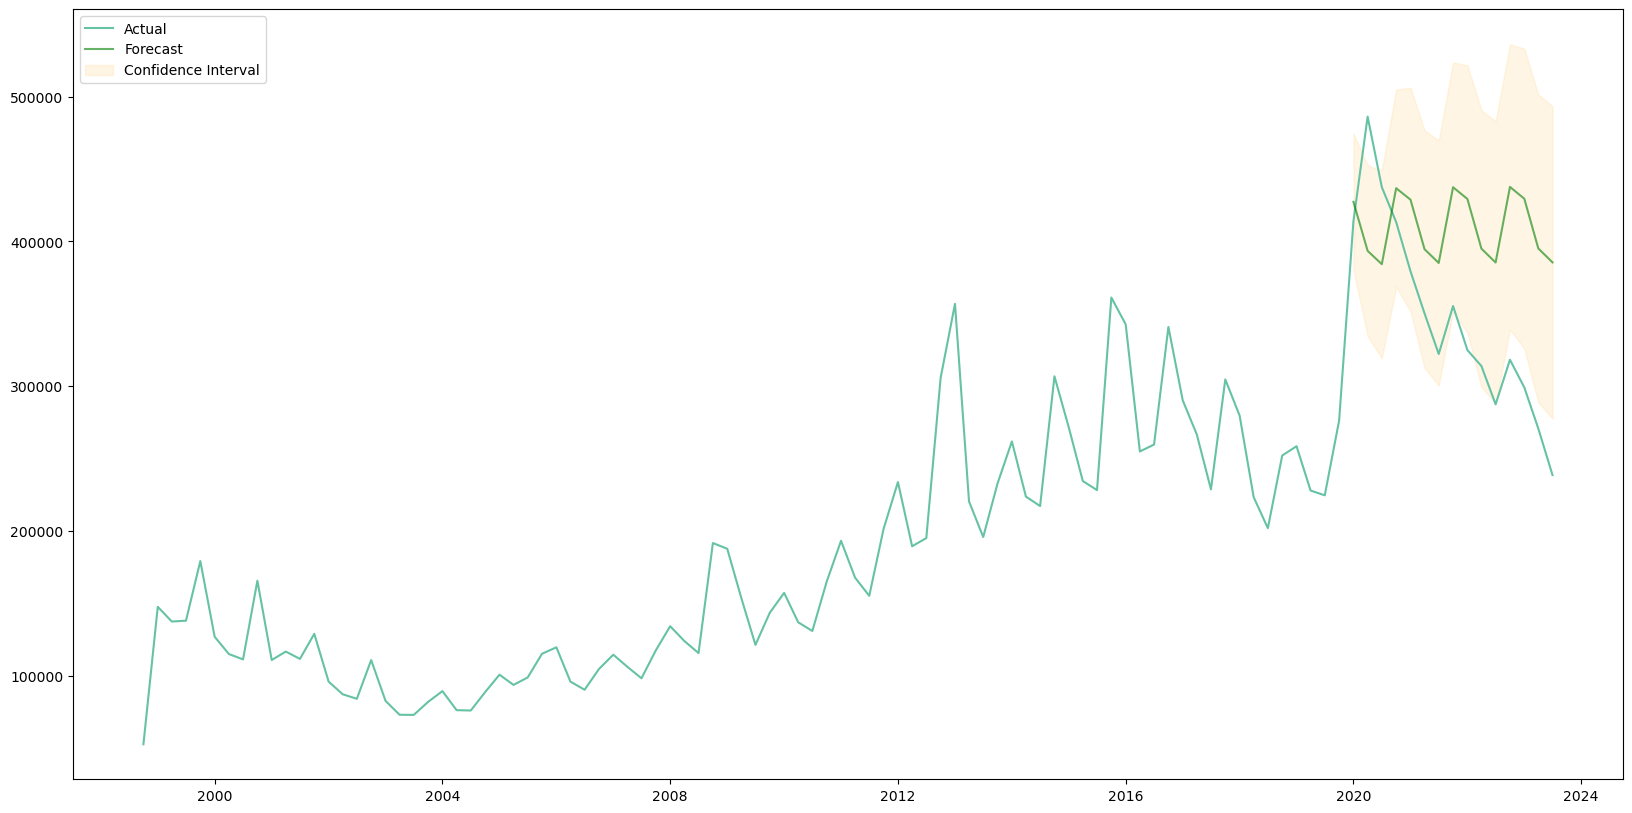

In [66]:
plt.figure(figsize = (20, 10))

#Plot our Actual Data
plt.plot(data.index, data, label = 'Actual')

#Plot forecasted Data
plt.plot(forecast_values.index, forecast_values, label = 'Forecast', color = 'green', alpha = .6)

#Plot Confidence Intervals
plt.fill_between(ciLower.index, ciLower, ciUpper, color = 'orange', alpha = .1, label = 'Confidence Interval')

plt.legend(loc = 'upper left')
plt.show()